In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import ARIMA, acf, pacf, datetools
import statsmodels.api as sm
from scipy import signal
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import seaborn as sns
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Загружаем данные 1129 региона (нумерация у меня немного сдвинулась в pkl файлах).

In [2]:
with open("./data/region_1128.pkl", "rb") as fid:
    data = pickle.load(fid, encoding='latin1')

p = pd.date_range('2014 Jan 1 00:00:00', periods = data.size, freq = 'h')

data_df = pd.DataFrame(data, columns = ['val'], index=[p])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21168 entries, 2014-01-01 00:00:00 to 2016-05-31 23:00:00
Freq: H
Data columns (total 1 columns):
val    21168 non-null float64
dtypes: float64(1)
memory usage: 330.8 KB


Возьмем данные за последние 5 месяцев.

In [3]:
ts_df = data_df['2016-01-01':].copy()
ts_df.head(5)

,val
2016-01-01 00:00:00,617.0
2016-01-01 01:00:00,453.0
2016-01-01 02:00:00,366.0
2016-01-01 03:00:00,309.0
2016-01-01 04:00:00,333.0


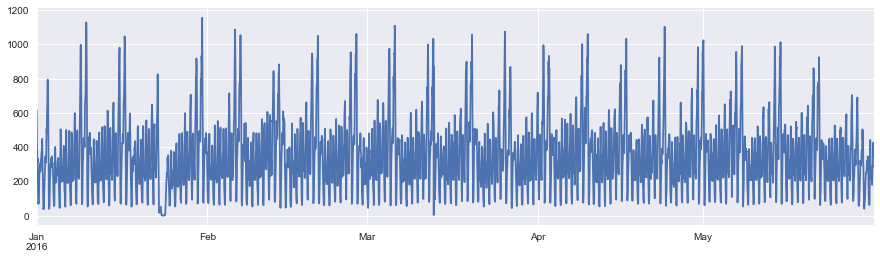

In [4]:
plt.figure(figsize=(15,4))
ts_df.val.plot()
plt.show()

Посмотрим на скользящее среднее и вариацию.

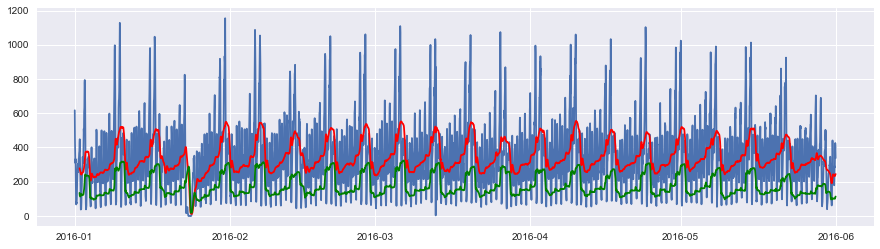

In [5]:
rolmean = ts_df.val.rolling(window=24).mean()
rolstd = ts_df.val.rolling(window=24).std()

plt.figure(figsize=(15,4))
plt.plot(ts_df.index, ts_df.val)
plt.plot(ts_df.index, rolmean, 'r')
plt.plot(ts_df.index, rolstd, 'g')

STL-декомпозиция

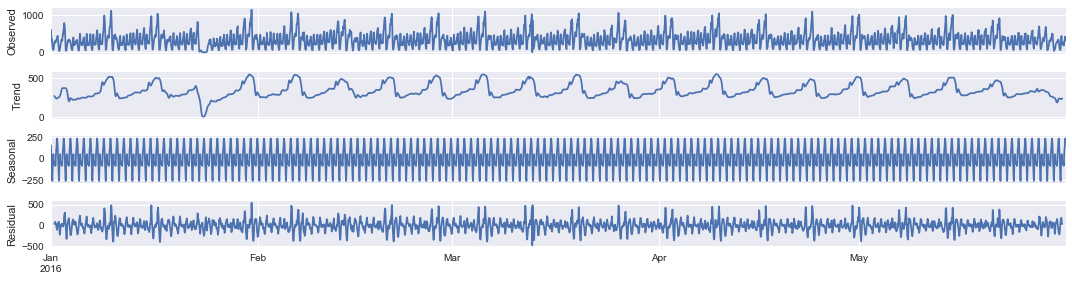

In [6]:
plt.figure(figsize(15,4))
sm.tsa.seasonal_decompose(ts_df, freq=24).plot();

Посмотрим, в какое время происходит "провал" в поездках на такси.

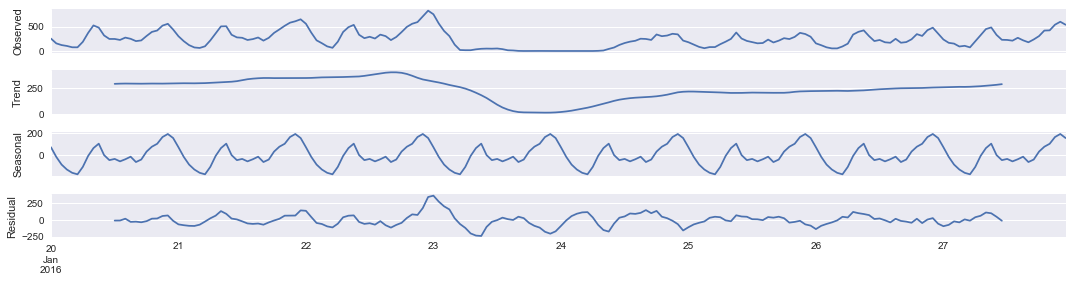

In [7]:
plt.figure(figsize(15,4))
sm.tsa.seasonal_decompose(ts_df.val.loc['2016-01-20':'2016-01-27'], freq=24).plot();

Аномалия 24 января связано со снежной бурей http://www.bbc.com/russian/international/2016/01/160124_snowstorm_us_sunday 
Ниже мы в модель добавим ее индикатор, также наблюдается снижение числа поездок в начале января и конце мая, что нужно будет учесть при построении модели.

Далее будем создавать регрессионные признаки для разложения в ряд Фурье. Будем варьировать число K (число компонент), и будем смотреть как изменяется MSE и корреляция с 168 лагом.

In [8]:
best_mse = float("inf")
str_reg = 'val ~ '
mse_list = []
lag_list = [] # 168 lag correlation
ts_df = data_df['2016-01-01':].copy()
length = ts_df.shape[0]
for num_end in range(1, 80):
    str_var = ''
    for i in range(1, num_end+1):
        #if i%7 == 0:
            #continue
        sin = "s_" + str(i)
        cos = "c_" + str(i)
        ts_df[sin] = np.sin(2*np.pi*i*np.arange(0, length)/168.0)
        ts_df[cos] = np.cos(2*np.pi*i*np.arange(0, length)/168.0)
        str_var = str_var + sin + ' + '
        if i != num_end:
            str_var = str_var + cos + ' + '
        else:
            str_var = str_var + cos
    m1 = smf.ols(str_reg + str_var, data=ts_df)
    fitted = m1.fit()
    lag_list.append(acf(fitted.resid, nlags=168)[168])
    if fitted.mse_resid < best_mse:
        best_mse = fitted.mse_resid
        best_param = num_end
    mse_list.append(fitted.mse_resid)

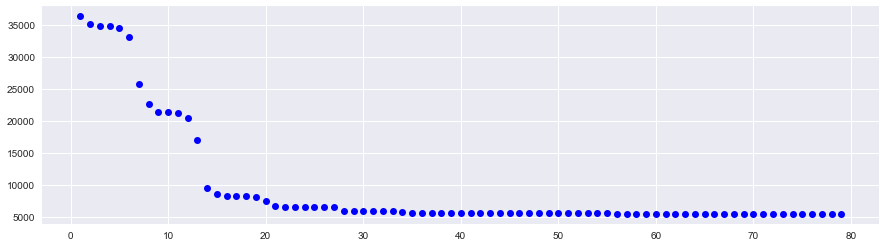

In [9]:
plt.plot(range(1, 80), mse_list, 'bo')

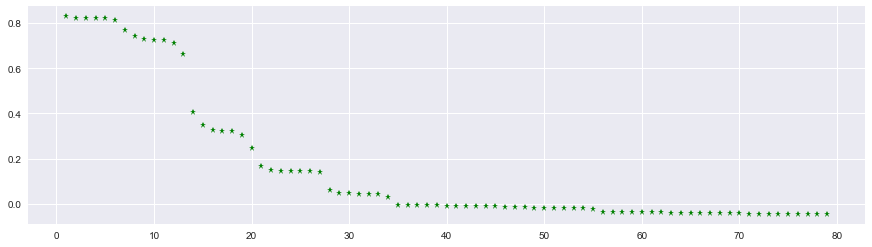

In [10]:
plt.plot(range(1, 80), lag_list, 'g*')

In [11]:
str_reg = 'val ~ '
str_reg_log = 'np.log(val + 100) ~ '
str_var = ''
num_end = 77
ts_df = data_df['2016-01-01':].copy()
length = ts_df.shape[0]
for i in range(1, num_end+1):
    #if i%7 == 0:
     #   continue
    sin = "s_" + str(i)
    cos = "c_" + str(i)
    ts_df[sin] = np.sin(2*np.pi*i*np.arange(1, length+1)/168.0)
    ts_df[cos] = np.cos(2*np.pi*i*np.arange(1, length+1)/168.0)
    str_var = str_var + sin + ' + '
    if i != num_end:
        str_var = str_var + cos + ' + '
    else:
        str_var = str_var + cos
ts_df.head()

,val,s_1,c_1,s_2,c_2,s_3,c_3,s_4,c_4,s_5,...,s_73,c_73,s_74,c_74,s_75,c_75,s_76,c_76,s_77,c_77
2016-01-01 00:00:00,617.0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,...,0.399892,-0.916562,0.365341,-0.930874,0.330279,-0.943883,0.294755,-0.955573,0.258819,-0.965926
2016-01-01 01:00:00,453.0,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,...,-0.733052,0.680173,-0.680173,0.733052,-0.623490,0.781831,-0.563320,0.826239,-0.500000,0.866025
2016-01-01 02:00:00,366.0,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,...,0.943883,-0.330279,0.900969,-0.433884,0.846724,-0.532032,0.781831,-0.623490,0.707107,-0.707107
2016-01-01 03:00:00,309.0,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,...,-0.997204,-0.074730,-0.997204,0.074730,-0.974928,0.222521,-0.930874,0.365341,-0.866025,0.500000
2016-01-01 04:00:00,333.0,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,...,0.884115,0.467269,0.955573,0.294755,0.993712,0.111964,0.997204,-0.074730,0.965926,-0.258819


In [12]:
m1 = smf.ols(str_reg + str_var, data=ts_df)
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     499.3
Date:                Sat, 01 Apr 2017   Prob (F-statistic):               0.00
Time:                        21:04:05   Log-Likelihood:                -20813.
No. Observations:                3648   AIC:                         4.194e+04
Df Residuals:                    3493   BIC:                         4.290e+04
Df Model:                         154                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    342.4293      1.217    281.363      0.0

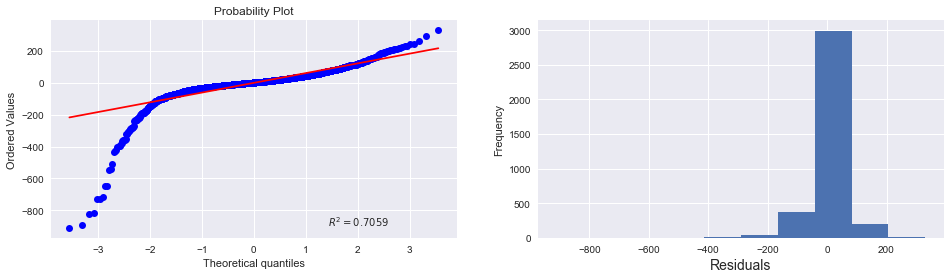

In [13]:
plt.figure(figsize(16,4))
plt.subplot(121)
ss.probplot(fitted.resid, dist="norm", plot=pylab, rvalue=True)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

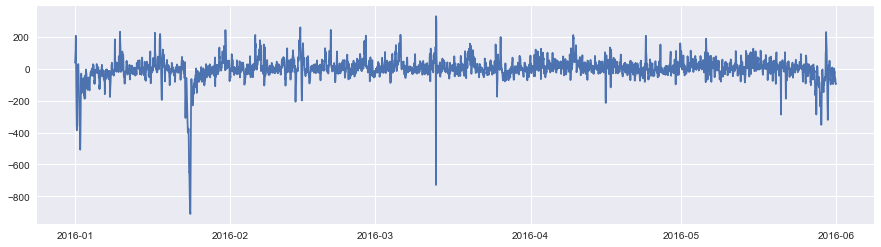

In [14]:
plt.figure(figsize=(15,4))
plt.plot(fitted.resid);

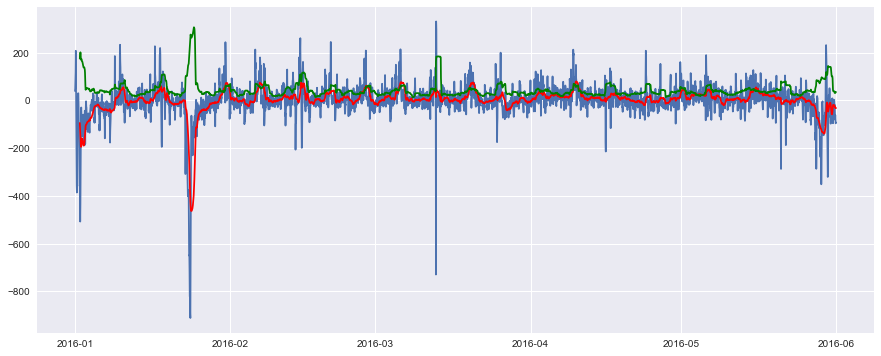

In [15]:
rolmean = fitted.resid.rolling(window=24).mean()
rolstd = fitted.resid.rolling(window=24).std()

plt.figure(figsize=(15,6))
plt.plot(fitted.resid)
plt.plot(rolmean, 'r')
plt.plot(rolstd, 'g')

Исходный ряд

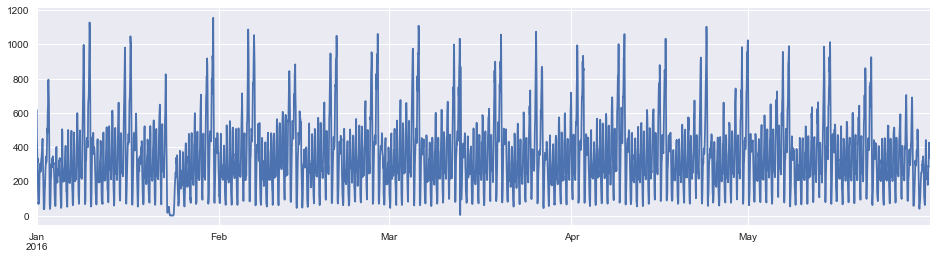

In [16]:
ts_df.val.plot()

Ряд, смоделированный с помощью тригонометрических признаков.

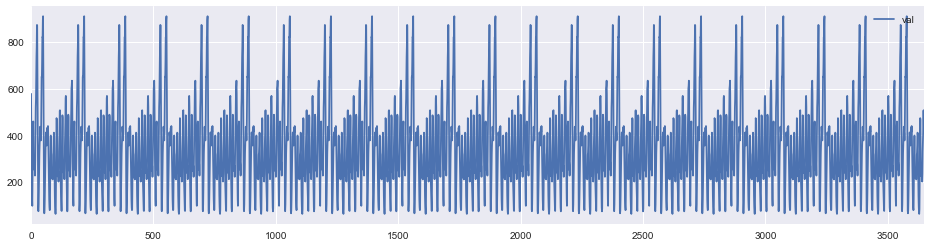

In [17]:
pred = pd.DataFrame(np.zeros((ts_df.shape[0], 1)), columns = ['val'])
for index in fitted.params.index:
    if index == 'Intercept':
        pred['val'] += fitted.params[index]
        continue
    pred['val'] += (ts_df[index]*fitted.params[index]).values
pred.plot()

Сравнение двух рядов.

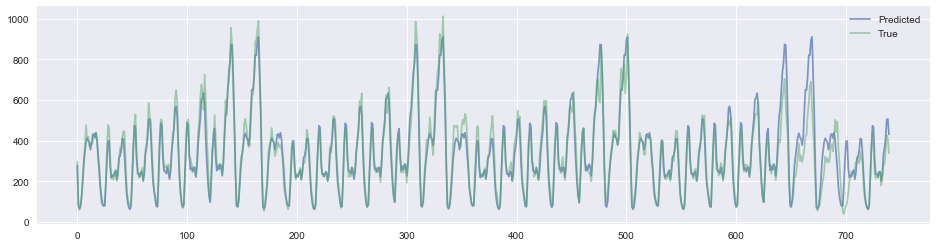

In [18]:
plt.plot(pred.values[-740:], alpha = 0.7, label='Predicted')
plt.plot(ts_df.val.values[-740:], alpha=0.5, label = 'True')
plt.legend()

Аномалия 23-24 января.

In [19]:
#ts_df['jan_anom'] = [1 if date.month == 1 and date.day in [23, 24] and date.year == 2016 else 0 for date in ts_df.index] *\
#                    np.sin(2.0*np.pi*np.arange(0, ts_df.shape[0])/168.0)
ts_df['jan_anom'] = [1 if date.month == 1 and date.day in [23, 24] and date.year == 2016 else 0 for date in ts_df.index] *\
                    pred.val.values

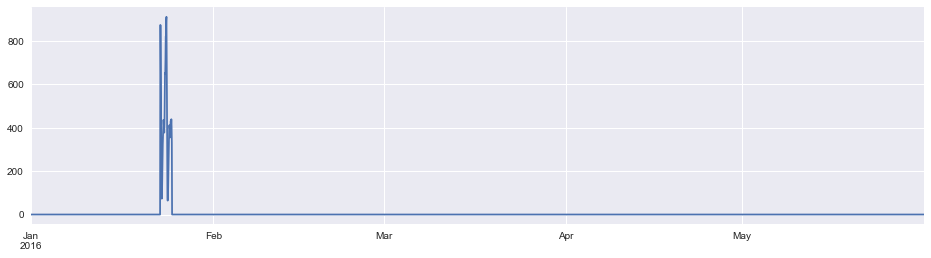

In [20]:
ts_df.jan_anom.plot()

In [22]:
m2 = smf.ols(str_reg + str_var + ' + jan_anom', data=ts_df)
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     554.2
Date:                Sat, 01 Apr 2017   Prob (F-statistic):               0.00
Time:                        21:04:24   Log-Likelihood:                -20071.
No. Observations:                3648   AIC:                         4.045e+04
Df Residuals:                    3492   BIC:                         4.142e+04
Df Model:                         155                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    346.7073      0.983    352.619      0.0

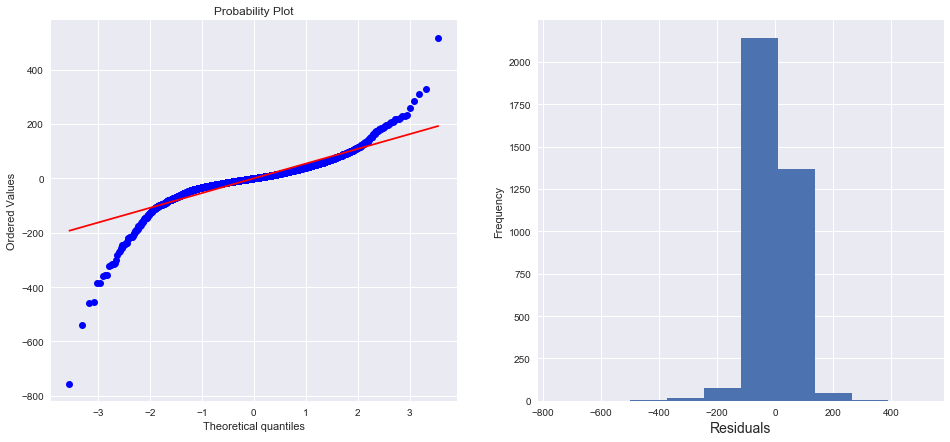

In [23]:
plt.figure(figsize(16,7))
plt.subplot(121)
ss.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

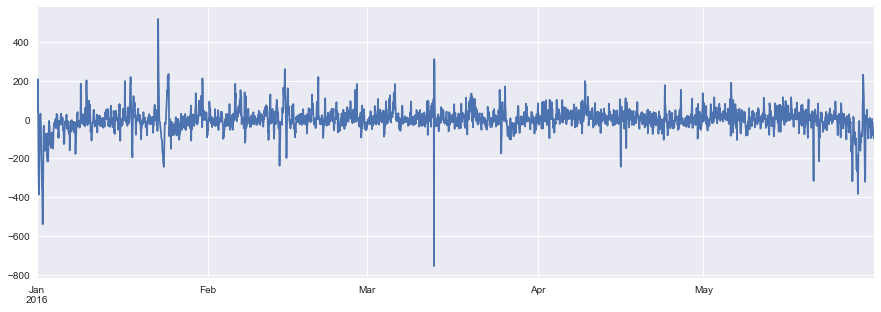

In [24]:
plt.figure(figsize=(15,5))
fitted.resid.plot()

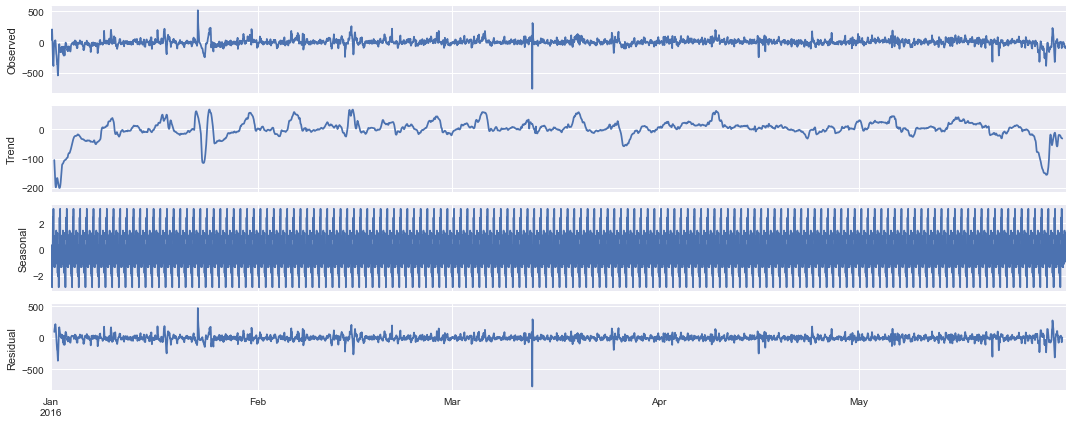

In [25]:
plt.figure(figsize(15,6))
sm.tsa.seasonal_decompose(fitted.resid, freq=24).plot();
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Посмотрим на график временного ряда в мае.

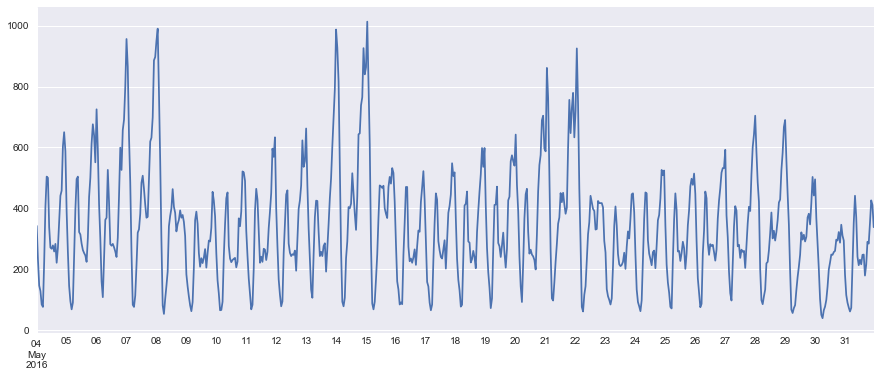

In [26]:
ts_df.val[-4*168:].plot()

Майское снижение числа поездок.

In [27]:
may_count = ts_df.index.size - ts_df.loc['2016-05-22':].index.size
may_count2 = ts_df.index.size - ts_df.loc['2016-05-28':].index.size
length = ts_df.shape[0]
#ts_df['x1_coef'] = [x if date < pd.datetime(2016,1,4,0) else 0 for x, date in zip(ts_df.]
ts_df['may_trend'] = [(ind - may_count) if date >= pd.datetime(2016,5,22,0) else 0 for ind, date in enumerate(ts_df.index)]
ts_df['may_trend2'] = [(ind - may_count2) if date >= pd.datetime(2016,5,28,0) else 0 for ind, date in enumerate(ts_df.index)]
#ts_df['x2_coef'] = np.arange(1, length+1, dtype=uint64)**2
str_trend = ' + may_trend + may_trend2'# + x2_coef'

Январское снижение числа поездок.

In [28]:
# Celebrations, pre- and post-celebration days
#ts_df['pre_new_year'] = [1 if date.month == 12 and date.day == 31 else 0 for date in p]
ts_df['jan_1'] = [1 if date.month == 1 and date.day == 1 else 0 for date in ts_df.index]
#ts_df['jan_2'] = [1 if date.month == 2 and date.day == 1 else 0 for date in ts_df.index]
ts_df['jan_2'] = [ind if date < pd.datetime(2016,1,4,1) else 0 for ind, date in enumerate(ts_df.index)]
#ts_df['jan_3'] = [1 if date.month == 2 and date.day == 1 else 0 for date in ts_df.index]

In [29]:
str_jan = ' + jan_1 + jan_2'

In [32]:
m2 = smf.ols(str_reg + str_var + ' + jan_anom' + str_jan + str_trend, data=ts_df)
fitted = m2.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                    val   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     472.1
Date:                Sat, 01 Apr 2017   Prob (F-statistic):               0.00
Time:                        21:04:38   Log-Likelihood:                -19839.
No. Observations:                3648   AIC:                         4.000e+04
Df Residuals:                    3488   BIC:                         4.099e+04
Df Model:                         159                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    352.0688      0.870    404.731      0.0

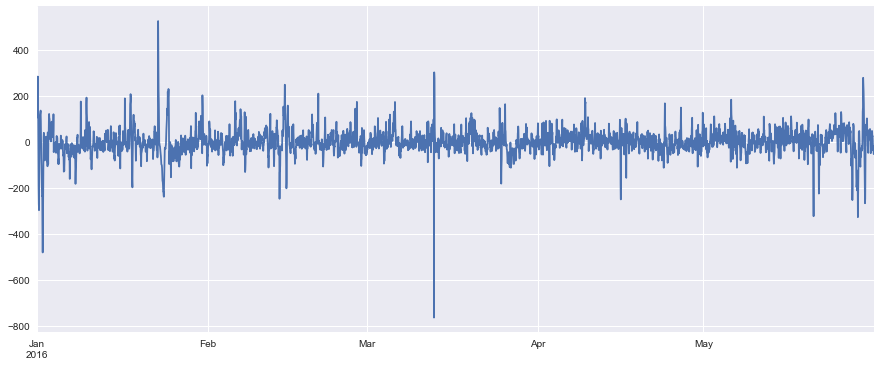

In [33]:
fitted.resid.plot()

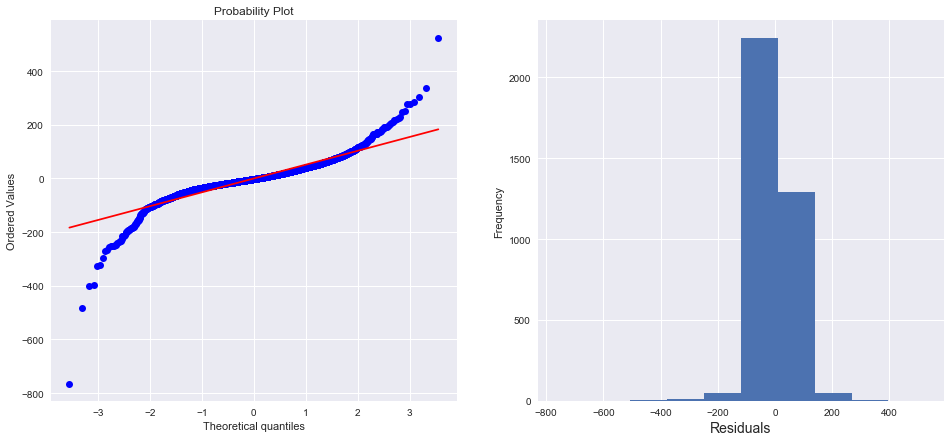

In [34]:
plt.figure(figsize(16,7))
plt.subplot(121)
ss.probplot(fitted.resid, dist="norm", plot=pylab)
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
pylab.show()

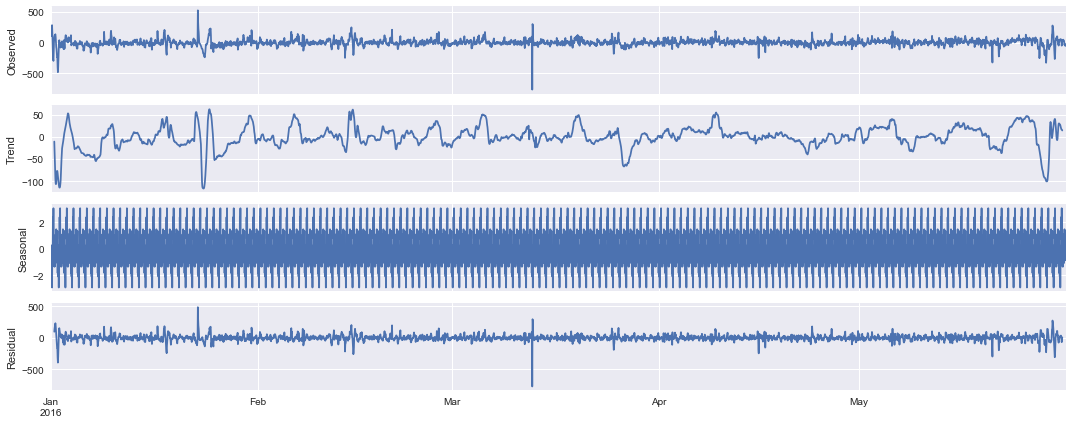

In [35]:
plt.figure(figsize(15,6))
sm.tsa.seasonal_decompose(fitted.resid, freq=24).plot();

Рассмотрим остатки.

In [36]:
resid = pd.DataFrame(fitted.resid, columns = ['val'], index=ts_df.index)
resid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3648 entries, 2016-01-01 00:00:00 to 2016-05-31 23:00:00
Freq: H
Data columns (total 1 columns):
val    3648 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


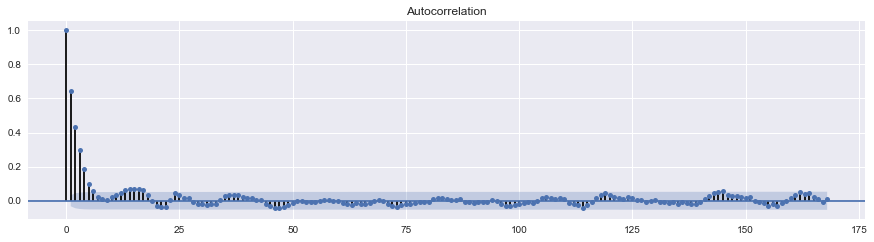

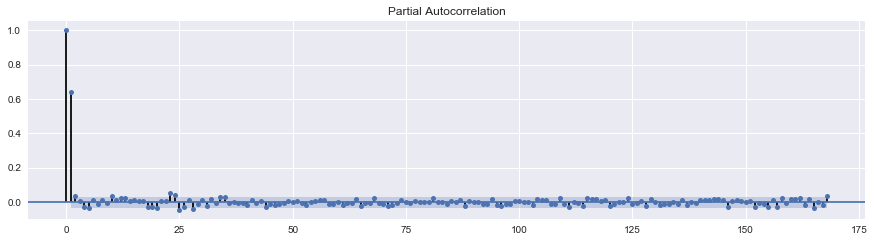

In [37]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.val.values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.val.values.squeeze(), lags=168, ax=ax)
pylab.show()

Выберем следующие параметры для SARIMAX: P= 1, p= 2, Q= 1, q=5

In [38]:
from itertools import product

In [39]:
ps = range(0, 2)
d=0
qs = range(0, 5)
Ps = range(0, 1)
D=0
Qs = range(0, 1)

In [40]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

10

In [41]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(ts_df.val, exog=ts_df[ts_df.columns[1:]], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 2, 0, 0)
wrong parameters: (0, 3, 0, 0)
wrong parameters: (0, 4, 0, 0)
Wall time: 9min 18s


In [42]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

     parameters           aic
5  (1, 4, 0, 0)  38170.622454
4  (1, 3, 0, 0)  38241.428242
3  (1, 2, 0, 0)  38326.854194
2  (1, 1, 0, 0)  38423.603627
1  (1, 0, 0, 0)  38645.710469


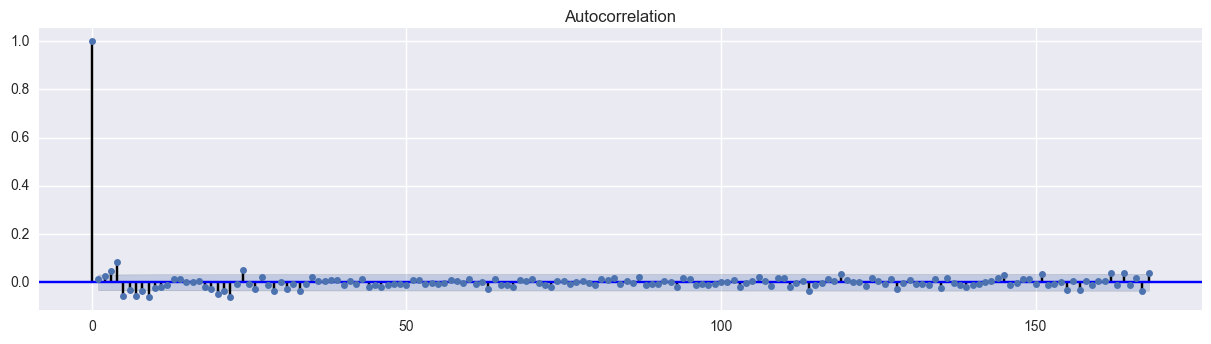

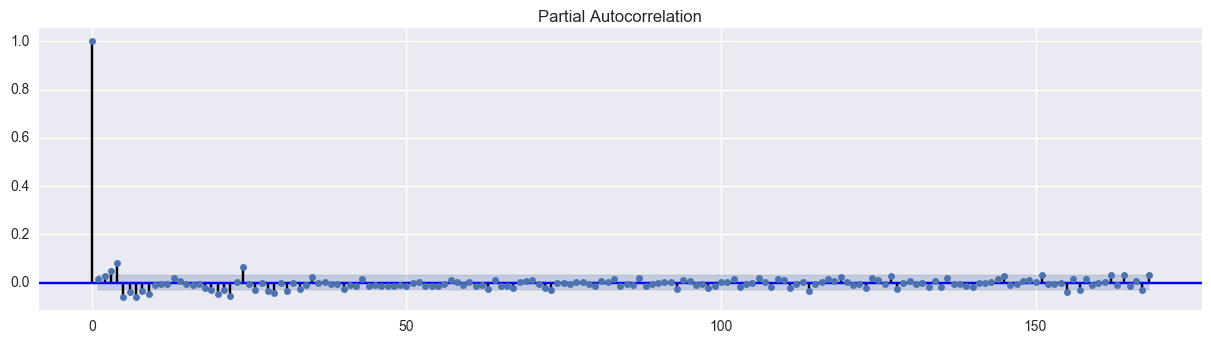

In [43]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(best_model.resid.values.squeeze(), lags=168, ax=ax)
pylab.show()

In [45]:
print ("Критерий Стьюдента: p=%f" % ss.ttest_1samp(best_model.resid[13:], 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Стьюдента: p=0.000399
Критерий Дики-Фуллера: p=0.000000


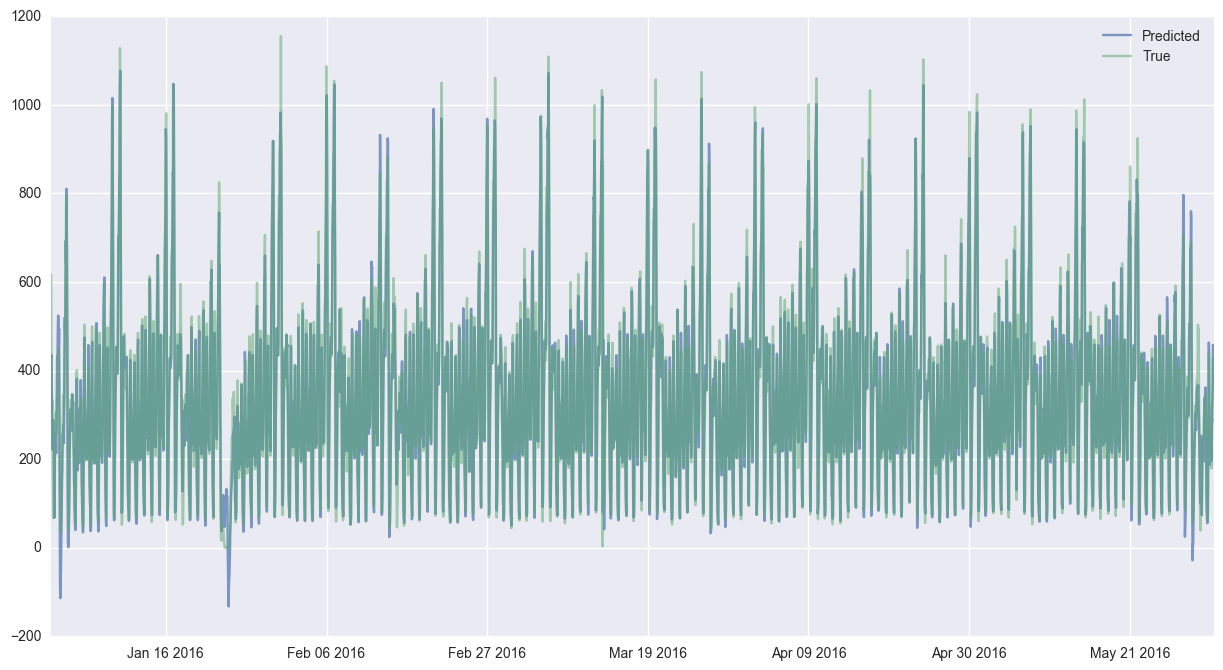

In [41]:
plt.plot(best_model.fittedvalues, alpha = 0.7, label='Predicted')
plt.plot(ts_df.val, alpha=0.5, label = 'True')
plt.legend()

Модель вполне адекватно описывает исходный временной ряд. Есть проблемы с описанием январской аномалии из-за погодных условий, и начало января. Первую аномалию сложно предсказать, а для второй аномалии скорее всего потребуеются годовые регрессионные признаки, поэтому в рамках тех исходных данных, которые были взяты, мы их учесть не можем. Модель достаточно холрошо описывает процесс.

(0, 1200)

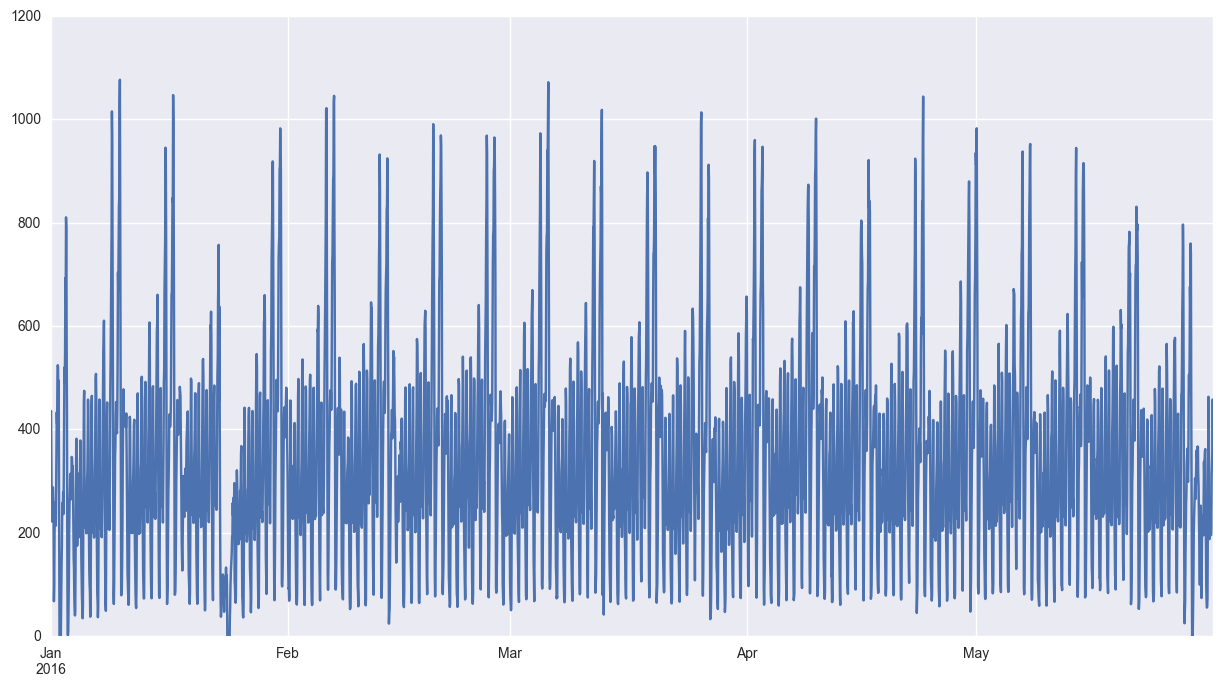

In [41]:
ax = best_model.fittedvalues.plot()
ax.set_ylim([0,1200])

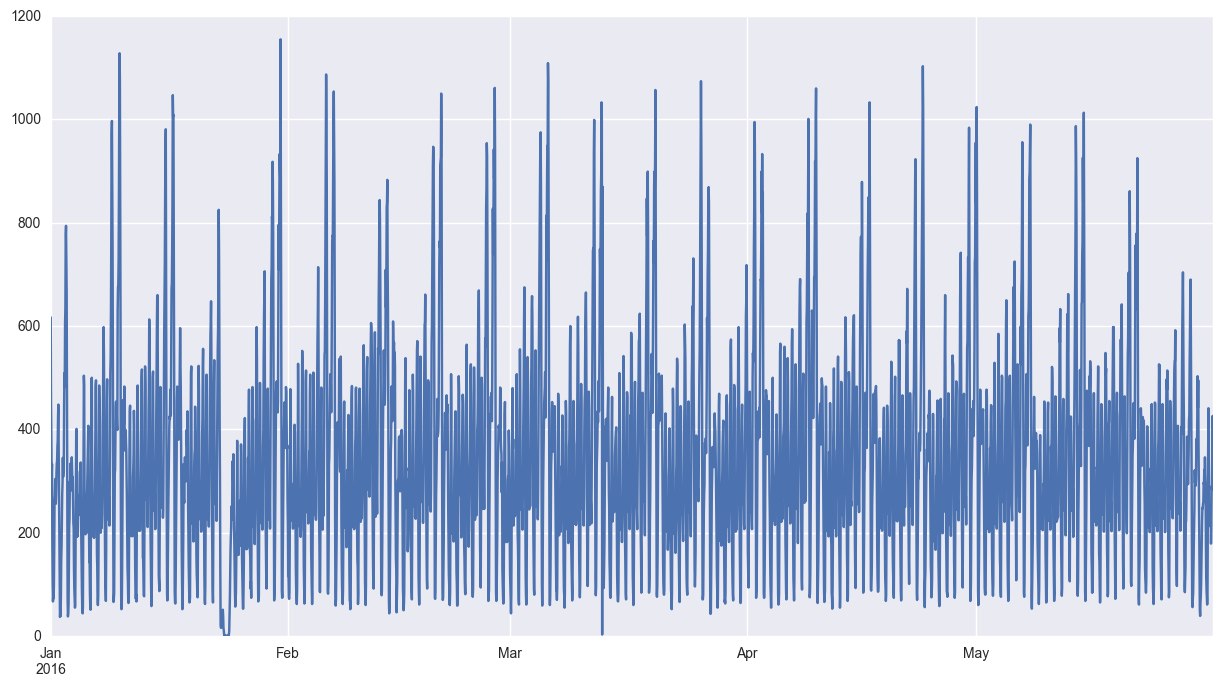

In [42]:
ts_df.val.plot()

А так выглядят исходный и предсказанный временные ряды.